## Summary of Findings

Based on the analysis of the Netflix dataset, here are the key insights:

*   **Content Distribution:** Movies significantly outnumber TV Shows in the Netflix catalog, making up approximately 72% of the content.
*   **Geographical Presence:** The United States has the largest contribution to the Netflix catalog, followed by India and the United Kingdom.
*   **Genre Popularity:** Dramas, International Movies, and Comedies are the most prevalent genres across the platform.
*   **Country-Specific Trends:**
    *   The United States dominates in various genres, particularly Comedies, Dramas, and Children & Family Movies.
    *   India has a strong focus on International Movies and Dramas.
    *   The United Kingdom shows a notable presence in British TV Shows and International TV Shows.
    *   Japan has a significant amount of Anime Series and International TV Shows.
    *   South Korea is a major contributor to International TV Shows and Korean TV Shows, with a strong presence in Romantic TV Shows and TV Dramas.
*   **Release and Addition Trends:** There's a sharp increase in content added to Netflix post-2010, indicating a period of significant expansion. While movies have a longer history on the platform, TV shows show a strong recent focus in production. The distribution of release years is skewed towards more recent years, with a peak around 2018.
*   **Addition Timing (Proxy for Launch Popularity):** Based on the date_added column, July and Fridays appear to be popular times for Netflix to add new movies, potentially indicating preferred launch timings.
*   **Actor and Director Influence:**
    *   Top actors across the catalog include those with strong presence in both Bollywood and Hollywood, reflecting the content mix.
    *   Top directors also represent a mix of regions, with a notable presence of directors from India and the US.
*   **Content Lag:** There is often a significant delay between a title's release year and when it is added to Netflix, with a wide distribution of these delays.
*   **TV Show Duration:** The majority of TV shows on Netflix have between 1 and 3 seasons, although there are some shows with a significantly higher number of seasons.
*   **Rating Distribution:** The most common ratings on Netflix are TV-MA, TV-14, and R, indicating a substantial amount of content targeted at mature audiences.

Overall, the analysis highlights Netflix's global reach with a diverse content library, a strong focus on original or recently released content, and distinct regional content preferences and production strengths.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
import calendar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown --fuzzy "***" --output netflix.csv

In [22]:
netflix_data = pd.read_csv('netflix.csv')
df = netflix_data.copy()

Netflix wants to understand which type of content (Movies or TV Shows) performs best across countries, and what genres, durations, and timings correlate with higher engagement potential.

Summary: 1:- 8,800+ records and 12 columns. 2:- Contains both numerical (years, duration) and categorical variables (type, director, cast, etc.)...  3:- Requires cleaning before analysis.

In [ ]:
# Quick views
print("Rows:", df.shape[0], "Columns:", df.shape[1])
print(df.info())
#print(df.describe(include='all').T.head(10))

Rows: 8807 Columns: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      8807 non-null   object        
 4   cast          8807 non-null   object        
 5   country       8807 non-null   object        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   Int64         
 8   rating        8807 non-null   object        
 9   duration      8807 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
 12  added_year    8807 non-null   int32         
 13  added_month   8709 non-null   float64       
dtypes: Int64(1), datetime64[ns](1), float64(1), int32(1), object(10)


# **Data Cleaning**

In [ ]:
# Clean column names (strip spaces)
df.columns = df.columns.str.strip()


# Replace NaN in all object (categorical) columns with "missing"
def replace_null(col):
    if col.dtype == 'object':
        return col.fillna("missing")
    return col

df = df.apply(replace_null)

# Convert relevant columns to categorical
for col in ['type', 'rating', 'country']:
    df[col] = df[col].astype('category')

# Convert date_added to datetime, extract year and month and release_year to Int64
if 'date_added' in df.columns:
  df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
  df["added_year"] = df["date_added"].dt.year.fillna(0).astype('int32')
  df["added_month"] = df["date_added"].dt.month
else:
    df['date_added'] = pd.NaT

if 'release_year' in df.columns:
    df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype('Int64')
    df['release_year'] = df['release_year'].fillna(0).astype('Int64')

# Trim whitespace in text columns
for c in ['type','title','director','cast','country','rating','listed_in','duration']:
    if c in df.columns:
        df[c] = df[c].astype(str).replace('nan','', regex=False).str.strip()

# For many analyses we will keep both original df and exploded df
df_explode = df.copy()

# exploding column to normalize data
df_explode["country"] = df_explode["country"].str.split(", ")
df_explode["director"] = df_explode["director"].str.split(", ")
df_explode["cast"] = df_explode["cast"].str.split(", ")
df_explode["listed_in"] = df_explode["listed_in"].str.split(", ")



df_explode = df_explode.explode("country").explode("director").explode("cast").explode("listed_in")

In [ ]:
df.head()
#df_explode.head(7)

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water          missing   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans          missing   
4      s5  TV Show           Kota Factory          missing   

                                                cast        country  \
0                                            missing  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        missing   
3                                            missing        missing   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

  date_added  release_year rating   duration  \
0 2021-09-25          2020  PG-13     90 min   
1 2021-09-24          2021  TV-MA  2 Seasons   
2 2021-09-24          2021  TV-MA   1 Season   
3 2021-09-24          2021  TV-MA   1 Season   
4 2021-09-24          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  added_year  added_month  
0  As her father nears the end of his life, filmm...        2021          9.0  
1  After crossing paths at a party, a Cape Town t...        2021          9.0  
2  To protect his family from a powerful drug lor...        2021          9.0  
3  Feuds, flirtations and toilet talk go down amo...        2021          9.0  
4  In a city of coaching centers known to train I...        2021          9.0

In [ ]:
info = df_explode.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201991 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   show_id       201991 non-null  object        
 1   type          201991 non-null  object        
 2   title         201991 non-null  object        
 3   director      201991 non-null  object        
 4   cast          201991 non-null  object        
 5   country       201991 non-null  object        
 6   date_added    200245 non-null  datetime64[ns]
 7   release_year  201991 non-null  Int64         
 8   rating        201991 non-null  object        
 9   duration      201991 non-null  object        
 10  listed_in     201991 non-null  object        
 11  description   201991 non-null  object        
 12  added_year    201991 non-null  int32         
 13  added_month   200245 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(1), int32(1), object(10)
memory usa

**We need to see which categories dominate (Movies vs TV Shows, top countries, genres).**

In [ ]:
print(df['type'].value_counts())
print("---------------------------------")
print(df['country'].value_counts().head(10))
print("---------------------------------")
print(df['listed_in'].nunique(), "unique genres")

type
Movie      6131
TV Show    2676
Name: count, dtype: int64
---------------------------------
country
United States     2818
India              972
missing            831
United Kingdom     419
Japan              245
South Korea        199
Canada             181
Spain              145
France             124
Mexico             110
Name: count, dtype: int64
---------------------------------
514 unique genres


**produced summary barplots for majour Catogericl column. This provides number of movies or tv shows in that entity. and listed top 3 for general inside how it's distributed between intaties**

In [ ]:
def summarize_exploded(df, col, top_n=10, plot=True):
    # Ensure 'df' exists and the column is in it
    if col not in df.columns:
        print(f"Error: Column '{col}' not found in DataFrame.")
        return None

    total_rows = len(df)

    # Correctly count 'missing' string and NaN values
    missing_count = ((df[col] == 'missing') | df[col].isna()).sum()

    # Filter out missing/NaN for unique count and value_counts
    temp_series = df[col].replace('missing', pd.NA).dropna()
    unique_count = temp_series.nunique()

    # Get top values from the cleaned series
    top_values = temp_series.value_counts().head(top_n)

    summary = {
        'column': col,
        'total_rows': total_rows,
        'unique_count': unique_count,
        'missing_count': int(missing_count),
        'top_3': top_values.head(3).to_dict()
    }

    print(f"\nSummary for '{col}': total_rows={total_rows}, unique={unique_count}, missing={missing_count}")
    print("Top 3:", summary['top_3'])

    if plot and not top_values.empty:
        # Plotting the data
        plt.figure(figsize=(8, max(2, top_n * 0.35)))
        # Sort in ascending order for horizontal bar chart (highest at top)
        plot_data = top_values.sort_values(ascending=True)
        sns.barplot(x=plot_data.values, y=plot_data.index)
        plt.title(f"Top {top_n} values for '{col}' (Total Counts)", fontsize=14)
        plt.xlabel("Count", fontsize=12)
        plt.tight_layout()
        plt.show()

    return summary

# Define the columns to process
cols = ['country', 'director', 'cast', 'listed_in']

# Dictionary to hold the summaries
summaries = {}


Summary for 'country': total_rows=201991, unique=127, missing=11897
Top 3: {'United States': 59349, 'India': 22814, 'United Kingdom': 12945}


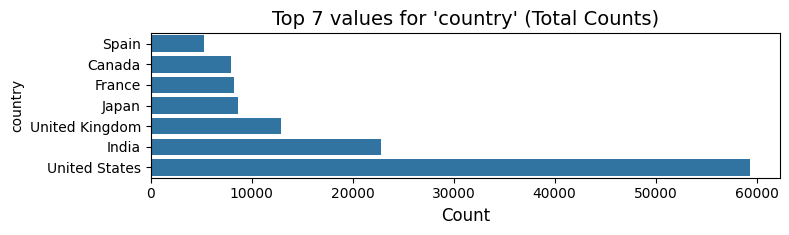

In [ ]:
summaries['country'] = summarize_exploded(df_explode, 'country', top_n=7)


Summary for 'director': total_rows=201991, unique=4993, missing=50643
Top 3: {'Martin Scorsese': 419, 'Youssef Chahine': 409, 'Cathy Garcia-Molina': 356}


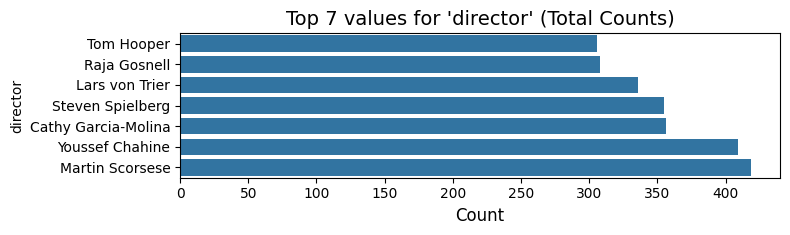

In [ ]:
summaries['director'] = summarize_exploded(df_explode, 'director', top_n=7)


Summary for 'cast': total_rows=201991, unique=36439, missing=2146
Top 3: {'Liam Neeson': 161, 'Alfred Molina': 160, 'John Krasinski': 139}


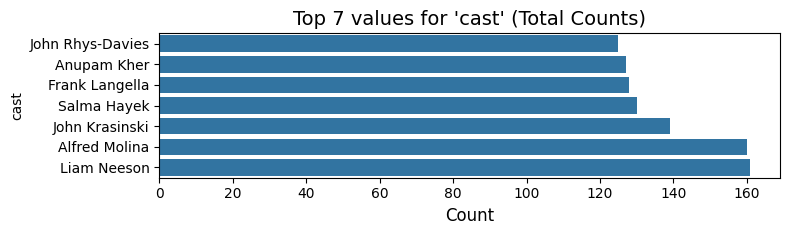

In [ ]:
summaries['cast'] = summarize_exploded(df_explode, 'cast', top_n=7)


Summary for 'listed_in': total_rows=201991, unique=42, missing=0
Top 3: {'Dramas': 29775, 'International Movies': 28211, 'Comedies': 20829}


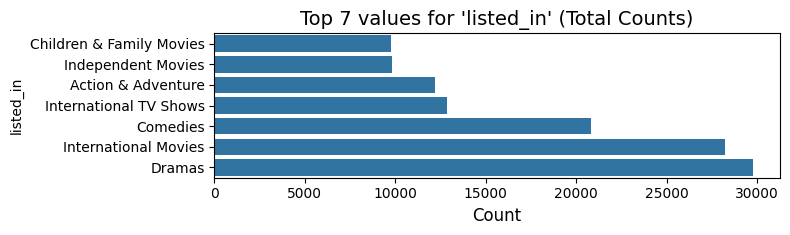

In [ ]:
summaries['listed_in'] = summarize_exploded(df_explode, 'listed_in', top_n=7)

**movies and Tv Shows dominate count-wise, trend plot shows type growth over years.**

In [ ]:
type_counts = df_explode['type'].value_counts()

# Trend by release_year
trend = (df_explode.dropna(subset=['release_year'])
         .groupby(['release_year','type'])
         .size().unstack(fill_value=0))
trend_recent = trend[trend.index >= 1990]
fig = px.line(trend_recent, x=trend_recent.index, y=trend_recent.columns, title="Titles by Release Year & Type (since 1990)")
fig.update_layout(xaxis_title='Release Year', yaxis_title='Count', legend_title='Type')
fig.show()

**shows which genres dominate in each major content-producing country. heatmap interactive.**

In [ ]:
#
country_genre = (df_explode
                 .groupby(['country','listed_in'])
                 .size()
                 .reset_index(name='count'))
top_countries = df_explode['country'].value_counts().head().index.tolist()

country_genre_top = {}
for country in top_countries:
    sub = country_genre[country_genre['country']==country].sort_values('count', ascending=False).head()
    country_genre_top[country] = list(zip(sub['listed_in'], sub['count']))

print("Top genres for top countries:")
for k,v in country_genre_top.items():
    print(k, "->", v)


Top genres for top countries:
United States -> [('Comedies', 8385), ('Dramas', 8173), ('Children & Family Movies', 4888), ('Action & Adventure', 4508), ('Independent Movies', 3901)]
India -> [('International Movies', 7059), ('Dramas', 5569), ('Comedies', 2685), ('Independent Movies', 1394), ('Action & Adventure', 1187)]
United Kingdom -> [('Dramas', 1939), ('British TV Shows', 1338), ('International Movies', 1189), ('Comedies', 975), ('International TV Shows', 905)]
missing -> [('International TV Shows', 1622), ('International Movies', 1598), ('Dramas', 958), ('TV Dramas', 868), ('Comedies', 786)]
Japan -> [('International TV Shows', 1809), ('Anime Series', 1785), ('Action & Adventure', 823), ('Anime Features', 814), ('International Movies', 810)]


In [ ]:
# Interactive heatmap style with Plotly
heat_df = country_genre[country_genre['country'].isin(top_countries) & country_genre['listed_in'].isin(df_explode['listed_in'].value_counts().head(10).index)]
pivot = heat_df.pivot(index='country', columns='listed_in', values='count').fillna(0)
fig = px.imshow(pivot.values, labels=dict(x="Genre", y="Country", color="Count"),
                x=pivot.columns, y=pivot.index, aspect="auto", color_continuous_scale='Blues', title="Top Countries vs Top Genres (counts)")
fig.show()

**Lists top actors and directors split by type. interactive top-actors bar.**

In [ ]:

actor_type = df_explode.groupby(['cast','type']).size().reset_index(name='count')
top_actors_movies = actor_type[actor_type['type']=='Movie'].sort_values('count', ascending=False).head()
top_actors_tv = actor_type[actor_type['type']=='TV Show'].sort_values('count', ascending=False).head()
print("Top actors - Movies:\n", top_actors_movies)
print("\nTop actors - TV:\n", top_actors_tv)

# Top directors by type
dir_type = df_explode.groupby(['director','type']).size().reset_index(name='count')
top_dirs_movies = dir_type[dir_type['type']=='Movie'].sort_values('count', ascending=False).head()
top_dirs_tv = dir_type[dir_type['type']=='TV Show'].sort_values('count', ascending=False).head()
print("\nTop directors - Movies:\n", top_dirs_movies)
print("\nTop directors - TV:\n", top_dirs_tv)


Top actors - Movies:
                  cast   type  count
40672         missing  Movie   1328
22114     Liam Neeson  Movie    161
1473    Alfred Molina  Movie    157
17699  John Krasinski  Movie    138
32969     Salma Hayek  Movie    130

Top actors - TV:
                      cast     type  count
40673             missing  TV Show    818
8805   David Attenborough  TV Show     82
36532    Takahiro Sakurai  TV Show     56
40191           Yuki Kaji  TV Show     45
787             Ai Kayano  TV Show     41

Top directors - Movies:
                  director   type  count
5061              missing  Movie   1285
2993      Martin Scorsese  Movie    419
5023      Youssef Chahine  Movie    409
767   Cathy Garcia-Molina  Movie    356
4497     Steven Spielberg  Movie    355

Top directors - TV:
              director     type  count
5062          missing  TV Show  49358
3434       Noam Murro  TV Show    189
4665    Thomas Astruc  TV Show    160
1772  Houda Benyamina  TV Show    104
987   Damien 

In [ ]:

# Plotly bar for top actors across both types (interactive)
ta = (actor_type.groupby(['cast']).agg({'count':'sum'}).reset_index().sort_values('count', ascending=False).head(10))
fig = px.bar(ta, x='count', y='cast', orientation='h', title='Top 15 actors across catalog (all types)')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

**Sharp increase post-2010 — Netflix expansion phase. TV shows are relatively newer, indicating recent production focus.**

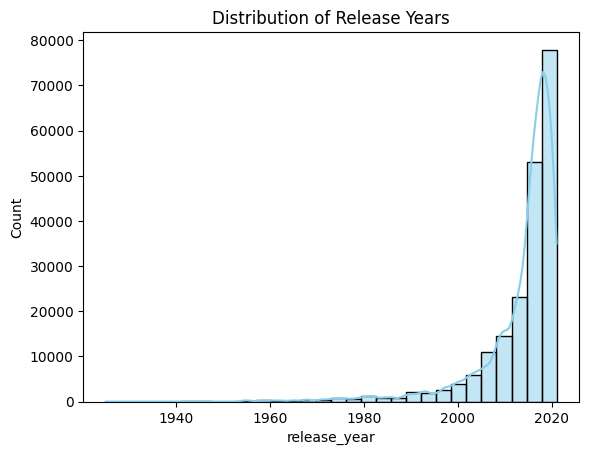

In [ ]:
sns.histplot(df_explode['release_year'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Release Years")
plt.show()


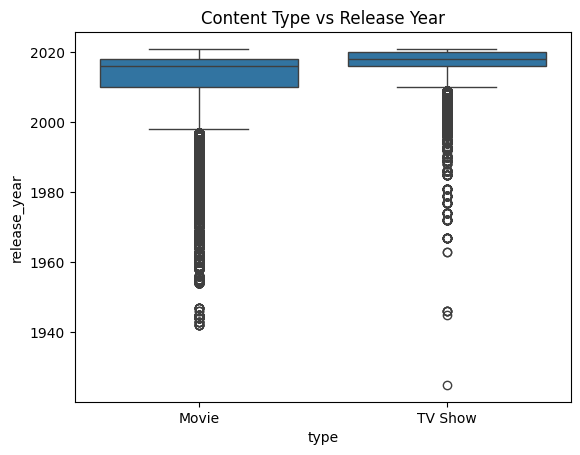

In [ ]:

sns.boxplot(data=df_explode, x='type', y='release_year')
plt.title('Content Type vs Release Year')
plt.show()

**shows country-level split. interactive grouped bar.**

In [ ]:
country_type = df_explode.groupby(['country','type']).size().unstack(fill_value=0)
country_type['total'] = country_type.sum(axis=1)
top10 = country_type.sort_values('total', ascending=False).head(10)
print(top10[['Movie','TV Show','total']])



type            Movie  TV Show  total
country                              
United States   45816    13533  59349
India           21411     1403  22814
United Kingdom   8560     4385  12945
missing          6199     5698  11897
Japan            3525     5154   8679
France           6607     1647   8254
Canada           5738     2177   7915
Spain            3469     1846   5315
South Korea      1289     3754   5043
Germany          3427      956   4383


In [ ]:
# Plotly grouped bar
top10_reset = top10.reset_index().melt(id_vars='country', value_vars=['Movie','TV Show'], var_name='type', value_name='count')
fig = px.bar(top10_reset, x='country', y='count', color='type', barmode='group', title='Top 10 countries by Movies vs TV Shows')
fig.show()

**month/weekday where Netflix historically adds most movies — use as launch proxy.**

In [ ]:
#Best time to launch a movie (proxy: when Netflix adds movies)
movies = df_explode[df_explode['type']=='Movie'].copy()
movies['added_month'] = movies['date_added'].dt.month
movies['added_weekday'] = movies['date_added'].dt.day_name()

# Month counts
month_counts = movies['added_month'].value_counts().sort_index()
month_labels = [calendar.month_name[m] if not pd.isna(m) else 'Unknown' for m in month_counts.index]
fig = px.bar(x=month_labels, y=month_counts.values, title='Movies added by month (proxy launch popularity)', height=250, width=400)
fig.update_layout(xaxis_title='Month', yaxis_title='Count')

# Weekday counts
weekday_counts = movies['added_weekday'].value_counts()
fig = px.bar(x=weekday_counts.index, y=weekday_counts.values, title='Movies added by weekday',height=350, width=800)
fig.update_layout(xaxis_title='Weekday', yaxis_title='Count')
fig.show()

# Print best month and weekday
if not month_counts.empty:
    best_month = calendar.month_name[int(month_counts.idxmax())]
else:
    best_month = None
best_weekday = weekday_counts.idxmax() if not weekday_counts.empty else None

print("Best weekday (by additions):", best_weekday)

Best weekday (by additions): Friday


In [ ]:

# Month counts
month_counts = movies['added_month'].value_counts().sort_index()
month_labels = [calendar.month_name[m] if not pd.isna(m) else 'Unknown' for m in month_counts.index]
fig = px.bar(x=month_labels, y=month_counts.values, title='Movies added by month (proxy launch popularity)',height=350, width=800)
fig.update_layout(xaxis_title='Month', yaxis_title='Count')
fig.show()

print("Best month (by additions):", best_month)

Best month (by additions): July


**wordcloud reveals common thematic words in descriptions.**

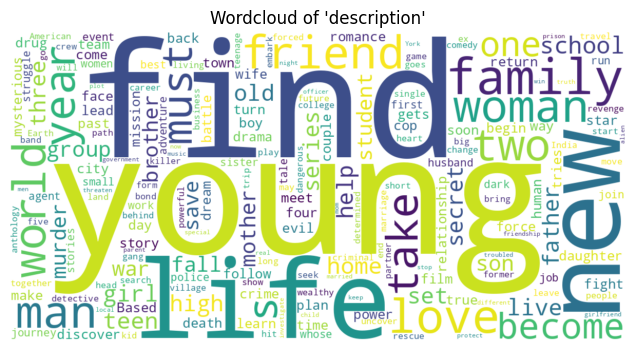

In [ ]:
#Wordcloud from 'description' (static)
desc_text = " ".join(df_explode['description'].astype(str).tolist())
stopwords = set(STOPWORDS)
wc = WordCloud(width=1200, height=600, background_color='white', stopwords=stopwords, collocations=False).generate(desc_text)
plt.figure(figsize=(10,4))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of 'description'")
plt.show()

**many titles added years after release. distribution printed.**

In [ ]:
#Relation: 'date_added' vs 'release_year'
rel = df_explode.dropna(subset=['date_added','release_year']).copy()
rel['added_year'] = rel['date_added'].dt.year
rel['delay_years'] = rel['added_year'] - rel['release_year']

# Plotly scatter with density information
fig = px.scatter(rel, x='release_year', y='added_year', opacity=0.4, marginal_x='histogram', marginal_y='histogram',
                 title="Release Year vs Year Added (scatter + marginals)")
fig.show()

In [ ]:
# Delay histogram
fig = px.histogram(rel, x='delay_years', nbins=50, title='Distribution of delay (years) between release and added')
fig.show()

**prints counts and top genres for Japan and Korea to validate the claim.**

In [ ]:
#Validate: Japan -> Anime? Korea -> Drama/Romance?
# Japan
japan = df_explode[df_explode['country'].str.contains(r'\bJapan\b', case=False, na=False)]
japan_anime = japan[japan['listed_in'].str.contains('Anime', case=False, na=False)]
print("Japan: total titles =", len(japan), ", Anime titles =", len(japan_anime))
print("Top genres in Japan:\n", japan['listed_in'].value_counts().head(10))

# Korea
korea = df_explode[df_explode['country'].str.contains(r'\bKorea\b', case=False, na=False)]
korea_drama = korea[korea['listed_in'].str.contains('Drama', case=False, na=False)]
korea_romance = korea[korea['listed_in'].str.contains('Romance', case=False, na=False)]
print("Korea: total titles =", len(korea), ", Drama titles =", len(korea_drama), ", Romance titles =", len(korea_romance))
print("Top genres in Korea:\n", korea['listed_in'].value_counts().head(10))

Japan: total titles = 8679 , Anime titles = 2599
Top genres in Japan:
 listed_in
International TV Shows      1809
Anime Series                1785
Action & Adventure           823
Anime Features               814
International Movies         810
Kids' TV                     309
Children & Family Movies     238
TV Dramas                    218
Romantic TV Shows            209
Dramas                       208
Name: count, dtype: int64
Korea: total titles = 5043 , Drama titles = 525 , Romance titles = 0
Top genres in Korea:
 listed_in
International TV Shows    1184
Korean TV Shows            972
Romantic TV Shows          593
International Movies       333
TV Dramas                  312
Dramas                     213
Comedies                   205
TV Comedies                194
Crime TV Shows             193
Action & Adventure         141
Name: count, dtype: int64


**shows which countries have longer movies on average.**

In [ ]:
# Function to extract the numeric part from the duration string
def extract_duration_number(row):
    duration = row['duration']
    if pd.isna(duration):
        return None

    parts = duration.split(' ')
    if parts[0].isdigit():
        return int(parts[0])
    return None

# Apply the function to create the required numeric column
df_explode['duration_num'] = df_explode.apply(extract_duration_number, axis=1)
movies = df_explode[df_explode['type'] == 'Movie'].copy()
mean_dur_country_series = movies.groupby('country')['duration_num'].mean().sort_values(ascending=False)

mean_dur_df = (
    mean_dur_country_series
    .head()
    .sort_values()
    .reset_index(name='Mean Duration (min)')
)

print("Mean movie duration by country (top 10):\n", mean_dur_country_series.head(10))



Mean movie duration by country (top 10):
 country
Liechtenstein    200.000000
Montenegro       157.000000
Soviet Union     156.636364
Bahamas          145.000000
Morocco          143.842697
Cameroon         143.000000
Malta            134.272727
Bangladesh       130.800000
India            129.406053
Pakistan         128.971175
Name: duration_num, dtype: float64


In [ ]:
# Plot top 5
fig = px.bar(
    mean_dur_df,
    x='Mean Duration (min)',
    y='country',
    orientation='h', height=350, width=800,
    title='Mean Movie Duration by Country (Top 5)')

fig.update_layout(xaxis_title='Mean minutes', yaxis_title='Country')
fig.show()

**most TV shows have 1–3 seasons; extremes printed.**


In [ ]:
#Number of seasons per TV show
tv = df[df['type']=='TV Show'].copy()
tv['seasons'] = tv['duration']
seasons_dist = tv['seasons'].value_counts().sort_values(ascending=False)
print("Seasons distribution (selection):\n", seasons_dist.head(10))



Seasons distribution (selection):
 seasons
1 Season      1793
2 Seasons      425
3 Seasons      199
4 Seasons       95
5 Seasons       65
6 Seasons       33
7 Seasons       23
8 Seasons       17
9 Seasons        9
10 Seasons       7
Name: count, dtype: int64


In [ ]:
# Plot distribution
fig = px.bar(x=seasons_dist.index.astype(str), y=seasons_dist.values, title='Seasons distribution per TV show')
fig.update_layout(xaxis_title='Seasons', yaxis_title='Count')
fig.show()

In [ ]:

# List shows with highest seasons reported
top_long = tv.sort_values('seasons', ascending=False)[['title','seasons']].drop_duplicates().head(10)
print("Shows with highest reported seasons:\n", top_long)

Shows with highest reported seasons:
                               title    seasons
1480                     Still Game  9 Seasons
6504       Club Friday The Series 6  9 Seasons
67                Saved by the Bell  9 Seasons
1998               Call the Midwife  9 Seasons
8     The Great British Baking Show  9 Seasons
8442              The Office (U.S.)  9 Seasons
5803                 Forensic Files  9 Seasons
3541                         Naruto  9 Seasons
1701          American Horror Story  9 Seasons
1933                      Wentworth  8 Seasons


**Rating composition, genre shifts over decades, and catalog growth trends.**

In [ ]:
# Popular genres by decade (heatmap via Plotly)
gtime = df_explode.dropna(subset=['release_year']).copy()
gtime['decade'] = (gtime['release_year'] // 10) * 10
top_genres = gtime['listed_in'].value_counts().head(12).index.tolist()
pivot = (gtime[gtime['listed_in'].isin(top_genres)]
         .groupby(['decade','listed_in']).size().unstack(fill_value=0).sort_index())
fig = px.imshow(pivot.values, x=pivot.columns, y=pivot.index, labels=dict(x='Genre', y='Decade', color='Count'), color_continuous_scale='Blues', title='Top genres by decade')
fig.show()

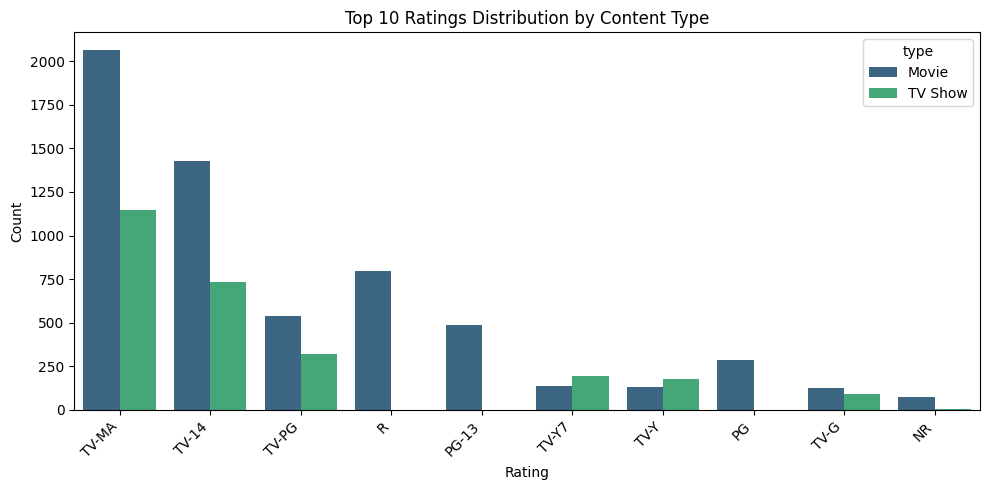

In [ ]:
# Analyzing the distribution of ratings by content type
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='rating', hue='type', palette='viridis', order=df['rating'].value_counts().index[:10])
plt.title('Top 10 Ratings Distribution by Content Type')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Movies ≈ 68% / TV Shows ≈ 32%**

In [ ]:
type_dist = df['type'].value_counts(normalize=True) * 100
print(type_dist)

type
Movie      69.615079
TV Show    30.384921
Name: proportion, dtype: float64


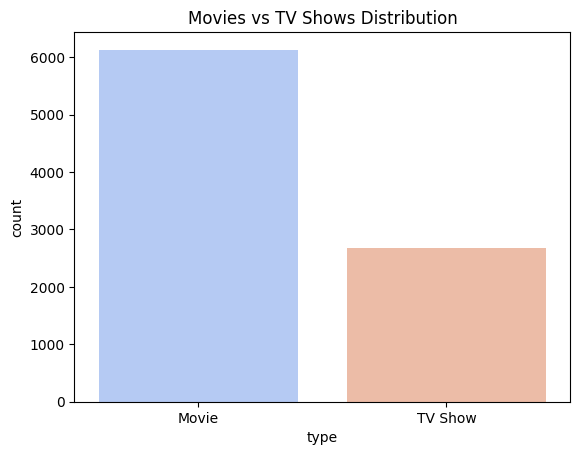

In [ ]:
sns.countplot(data=df, x='type', hue='type', palette='coolwarm', legend=False)
plt.title('Movies vs TV Shows Distribution')
plt.show()

**US leads both movies and shows by far. India and UK are strong in movies, while South Korea dominates in TV shows.**

In [ ]:
country_type = df_explode.groupby(['country', 'type']).size().reset_index(name='count')
top_countries = country_type.groupby('country')['count'].sum().nlargest(10).index
country_type_top = country_type[country_type['country'].isin(top_countries)]

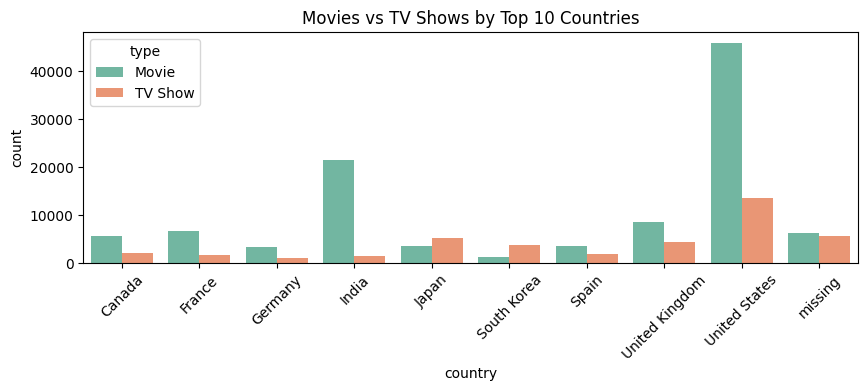

In [ ]:
plt.figure(figsize=(10,3))
sns.barplot(data=country_type_top, x='country', y='count', hue='type', palette='Set2')
plt.title('Movies vs TV Shows by Top 10 Countries')
plt.xticks(rotation=45)
plt.show()

**Top directors: Rajiv Chilaka, Marcus Raboy, Jay Karas — many from India and the US. Top actors: Anupam Kher, Shah Rukh Khan, Adam Sandler — reflects strong Bollywood + Hollywood presence.**

In [ ]:
# Top 10 directors
top_directors = df_explode[df_explode['director'] != 'missing']['director'].value_counts().head(5)
print(top_directors)

print("-------------------------------")
# Top 10 actors
top_actors = df_explode[df_explode['cast'] != 'missing']['cast'].value_counts().head(5)
print(top_actors)

director
Martin Scorsese        419
Youssef Chahine        409
Cathy Garcia-Molina    356
Steven Spielberg       355
Lars von Trier         336
Name: count, dtype: int64
-------------------------------
cast
Liam Neeson       161
Alfred Molina     160
John Krasinski    139
Salma Hayek       130
Frank Langella    128
Name: count, dtype: int64
